In [3]:
from HH_simulators import HodgkinHuxley, sample_box
from hh_utils import HodgkinHuxleyStatsMoments
import numpy as np
import time
import pickle
import torch
import sys

import matplotlib.pyplot as plt

In [4]:
#Define some fixed global parameters

n_mom = 4

allen_params = {"V0": -70.0, "I_on":100,"I_off":200,"t_max":300,"dt":0.01,"curr_level":5e-4,"A_soma": np.pi * ((70.0 * 1e-4) ** 2)}

duration = allen_params["t_max"]
t_on = allen_params["I_on"]
t_off = allen_params["I_off"]
dt = allen_params["dt"]
curr_level = allen_params["curr_level"]
A_soma = allen_params["A_soma"]

t = np.arange(0, duration + dt, dt)
I = np.zeros_like(t)
I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = curr_level / A_soma

sim = HodgkinHuxley(
    I, dt, V0=allen_params["V0"], reduced_model=False, cython=True, prior_log=False
)

stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_mom=n_mom,t_min=0.0, t_max=duration, dt=dt
)

In [5]:
def HH_simulator(theta,seed=None):
    #The simulator takes parameters theta in this order:
    #gbar_Na, gbar_K, g_leak, gbar_M, tau_max, Vt, nois_fact, E_leak

    #trace is the simulated voltage trace (timeseries)
    trace = [sim.gen_single(theta, seed=seed)["data"]]

    #We also calculate the expert summary stats, which are defined as:
    #spike_count, resting_potential, mean_potential, std_potential, skewness_potential, kurtosis_potential of the voltage trace
    expert_summary_stats = stats.calc(trace)
    return trace, expert_summary_stats

In [6]:
#This is the same prior used to generate the 10**5 simulations and summary stats provided.
def sample_prior(size,low= torch.Tensor([0.5, 1e-4, 1e-4, 1e-4, 50.0, 40.0, 1e-4, 35.0]),
            high = torch.Tensor([80.0, 15.0, 0.6, 0.6, 3000.0, 90.0, 0.15, 100.0]),
            seed=None):

    return (
        torch.distributions.Independent(
            torch.distributions.Uniform(low=low, high=high),
            reinterpreted_batch_ndims=1,
        )
        .sample((size,))
    )

theta = sample_prior(1).squeeze().numpy()
print(theta)

[6.7770325e+01 1.4063029e+01 5.6165820e-01 4.2721936e-01 2.8128865e+03
 4.9092113e+01 2.5597272e-02 6.4386963e+01]


In [7]:
trace,ss = HH_simulator(theta)

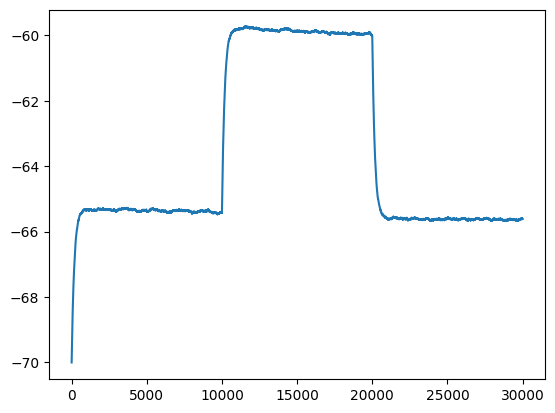

In [8]:
#A random simulation is not likely to look very good...
plt.plot(trace[0])


In [9]:
#And the summary statistics are also returned.
print(ss)

[[  0.         -65.43527836 -59.9672493    0.25208963  -6.98514191
   57.21630139]]


[[  5.         -72.93881477 -63.76067457 499.34781475   3.85745595
   17.67812773]]


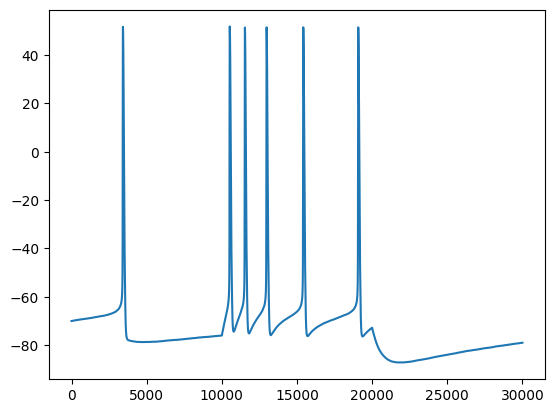

In [10]:
#But if we get lucky, some parameters from the prior lead to realistic looking simulations!
theta = torch.Tensor([7.3407e+01, 3.0328e+00, 7.2189e-02, 2.8311e-01, 9.8856e+02, 7.1609e+01,2.2578e-02, 6.5132e+01])
trace,ss = HH_simulator(theta.numpy())
plt.plot(trace[0])
print(ss)